In [ ]:
# Author: Nicholas Chludzinski

In [ ]:
"""
Heart Disease Prediction using Gradient Boosting + GridSearchCV
---------------------------------------------------------------

This script builds a complete supervised machine learning pipeline for predicting
heart disease using a tabular clinical dataset. It includes:

1. Data loading and preprocessing
   - Whitespace cleanup
   - Handling missing values
   - One-hot encoding of categorical variables
   - Binary mapping of Yes/No fields
   - Train/test split with stratification
   - Feature scaling using StandardScaler

2. Model training
   - GradientBoostingClassifier
   - Hyperparameter tuning with GridSearchCV (5-fold CV)

3. Model evaluation
   - Accuracy, classification report, confusion matrix
   - ROC curve and AUC score

4. Visualization
   - ROC curve plot

This template can be reused for any binary classification task involving
tabular data and demonstrates a clean, production-style ML workflow.
"""

In [75]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

In [76]:
# Choose Model
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
# Choose metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [78]:
# Load file and preprocess
df = pd.read_csv('/Users/nicho/Downloads/heart_disease_dataset.csv')

# Strip whitespace
df.columns = df.columns.str.strip()

# Drop columns with no values
df = df.dropna()

In [79]:
# View first few rows of dataset
df.head()

,Age,Gender,Cholesterol,Blood Pressure,Heart Rate,Smoking,Alcohol Intake,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Chest Pain Type,Heart Disease
0,75,Female,228,119,66,Current,Heavy,1,No,No,Yes,8,119,Yes,Atypical Angina,1
2,53,Male,234,91,67,Never,Heavy,3,Yes,No,Yes,5,196,Yes,Atypical Angina,1
6,64,Female,211,105,86,Former,Heavy,8,Yes,Yes,Yes,2,120,No,Typical Angina,1
7,60,Female,208,148,83,Never,Moderate,4,No,Yes,Yes,2,113,Yes,Asymptomatic,1
8,37,Female,317,137,66,Current,Heavy,3,No,Yes,Yes,5,114,No,Non-anginal Pain,0


In [80]:
print(df.columns.tolist())

['Age', 'Gender', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Smoking', 'Alcohol Intake', 'Exercise Hours', 'Family History', 'Diabetes', 'Obesity', 'Stress Level', 'Blood Sugar', 'Exercise Induced Angina', 'Chest Pain Type', 'Heart Disease']


In [81]:
# We don't need to change the target column (Heart Disease) to binary since it's already binary, but we DO need to
# one-hot-encode the columns that have strings (Gender, Smoking, Alcohol Intake, Chest Pain Type)
df = pd.get_dummies(df, columns=["Smoking", "Alcohol Intake", "Chest Pain Type", "Gender"], drop_first=True)

# AND map yes/no columns (Family History, Diabetes, Obesity, Exercise Induced Angina)
binary_cols = ["Family History", "Diabetes", "Obesity", "Exercise Induced Angina"]
for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [82]:
print(df.columns.tolist())

['Age', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Exercise Hours', 'Family History', 'Diabetes', 'Obesity', 'Stress Level', 'Blood Sugar', 'Exercise Induced Angina', 'Heart Disease', 'Smoking_Former', 'Smoking_Never', 'Alcohol Intake_Moderate', 'Chest Pain Type_Atypical Angina', 'Chest Pain Type_Non-anginal Pain', 'Chest Pain Type_Typical Angina', 'Gender_Male']


In [83]:
df.head()

,Age,Cholesterol,Blood Pressure,Heart Rate,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Heart Disease,Smoking_Former,Smoking_Never,Alcohol Intake_Moderate,Chest Pain Type_Atypical Angina,Chest Pain Type_Non-anginal Pain,Chest Pain Type_Typical Angina,Gender_Male
0,75,228,119,66,1,0,0,1,8,119,1,1,False,False,False,True,False,False,False
2,53,234,91,67,3,1,0,1,5,196,1,1,False,True,False,True,False,False,True
6,64,211,105,86,8,1,1,1,2,120,0,1,True,False,False,False,False,True,False
7,60,208,148,83,4,0,1,1,2,113,1,1,False,True,True,False,False,False,False
8,37,317,137,66,3,0,1,1,5,114,0,0,False,False,False,False,True,False,False


In [84]:
# Identify target column
TARGET_COLUMN = 'Heart Disease'

# Drop target column
X = df.drop([TARGET_COLUMN], axis=1)

# Define our target variable, the variable we are trying to predict
y = df[TARGET_COLUMN]

# View our new dataset (with the target column removed)
X.head()

,Age,Cholesterol,Blood Pressure,Heart Rate,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Smoking_Former,Smoking_Never,Alcohol Intake_Moderate,Chest Pain Type_Atypical Angina,Chest Pain Type_Non-anginal Pain,Chest Pain Type_Typical Angina,Gender_Male
0,75,228,119,66,1,0,0,1,8,119,1,False,False,False,True,False,False,False
2,53,234,91,67,3,1,0,1,5,196,1,False,True,False,True,False,False,True
6,64,211,105,86,8,1,1,1,2,120,0,True,False,False,False,False,True,False
7,60,208,148,83,4,0,1,1,2,113,1,False,True,True,False,False,False,False
8,37,317,137,66,3,0,1,1,5,114,0,False,False,False,False,True,False,False


In [85]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [86]:
# Standardize using standard scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [87]:
# Use GridSearchCV to find best parameters (hyperparameter tuning):

# Define the parameters
param_grid = {
    'n_estimators':[50, 100, 150],
    'learning_rate':[0.01, 0.1, 0.2],
    'max_depth':[3, 5, 7]
}


# Create the GridSearchCV object AND choose the model here
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)


# Fit the grid search on the training data
grid_search.fit(X_train, y_train)


# Extract the best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


# Use the tuned model for predictons
y_pred = best_model.predict(X_test)

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


In [88]:
# Choose model (if not using GridSearchCV)
#model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [89]:
# Fit the model to the training data and predict on the test data (if not using GridSearchCV)
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

In [90]:
# See our metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

Accuracy: 1.0
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        52

    accuracy                           1.00       132
   macro avg       1.00      1.00      1.00       132
weighted avg       1.00      1.00      1.00       132

Confusion Matrix: [[80  0]
 [ 0 52]]


In [91]:
# ROC and AUC (Closer to 1 the better and more accurate
y_pred_proba = best_model.predict_proba(X_test)[:, 1]   # use best_model instead of model since I used GridSearchCV
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

AUC Score: 1.0


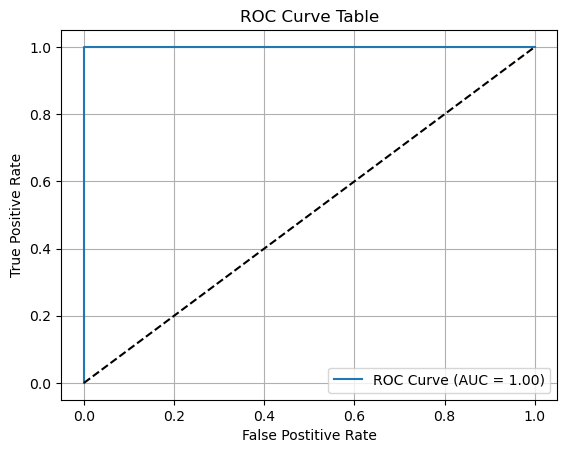

In [93]:
# Plot ROC Curve (closer to top left the better)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagnol line
plt.xlabel("False Postitive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Table")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()